In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from astropy.io import fits
from astropy.wcs import WCS
import healpy as hp
import reproject

In [3]:
from __future__ import unicode_literals

figsize(8,6)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 12
rcParams['legend.borderaxespad'] = 2

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [4]:
lonc = 107.2
latc = 5.2
lonra = [105.6, 108.8]
latra = [3.6, 6.8]
d2r = np.pi / 180.

In [5]:
bank = 'A'

In [6]:
imfile = fits.open('destripingdata_bank'+bank+'_session5_weights1.fits')

In [7]:
hits = np.load('hitsA.npy')

In [8]:
noisemap = imfile[5].data / hits
noisemap[hits==0] = np.nan

ValueError: operands could not be broadcast together with shapes (180,180) (176,173) 

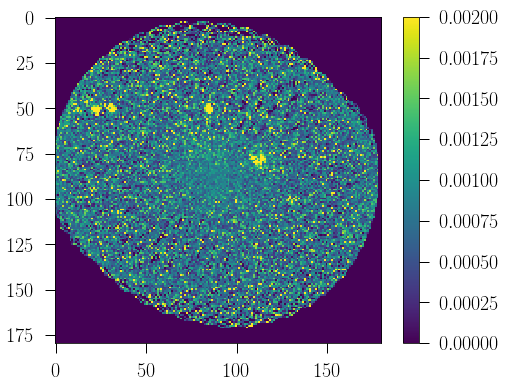

In [9]:
imshow(imfile[5].data)
colorbar()
clim(0, 0.002)

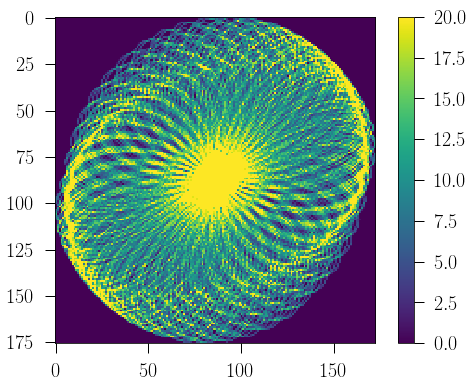

In [10]:
imshow(hits)
colorbar()
clim(0, 20)

In [11]:
def plot_destriped(bank='A', removeplane=True, sbeam=0., nside=4096):
    imfile = fits.open('destripingdata_bank'+bank+'_session5_weights1.fits')

    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq

    pixbeam = 1. 
    beamarea = np.pi / (4. * np.log(2)) * (beam / 60. * d2r)**2
    units = 1. / beamarea

    newbeam = np.sqrt(beam**2 - pixbeam**2)
    sigma = newbeam / pixbeam / (2. * np.sqrt(2. * np.log(2)))

    mdata = imfile[0].data
    datamap = gaussian_filter(mdata, sigma) * units 

    hitmask = imfile[0].data != 0
    hits = np.zeros_like(imfile[0].data)
    hits[hitmask] = 1.
    shits = gaussian_filter(hits, sigma)

    if removeplane:
        X = np.arange(180)
        RX, RY = np.meshgrid(X, X)
        radius = np.sqrt((RX-90)**2 + (RY-90)**2)
        rmask = radius < 25

        XX = RX.flatten()
        YY = RY.flatten()
        Z = datamap.flatten()
        mask = Z == 0 
        Z[mask] = np.nan
        masks = ~np.isnan(Z) * ~rmask.flatten()
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * RX + C[1] * RY + C[2]
        datamap -= res

    if sbeam > 0:
        newbeam = np.sqrt(sbeam**2 - beam**2)
        sigma = newbeam / pixbeam / (2. * np.sqrt(2. * np.log(2)))
        datamap = gaussian_filter(datamap, sigma) 

    mask = shits < 0.3
    datamap[mask] = np.nan
    imfile[0].data = datamap
    hpimage, footprint = reproject.reproject_to_healpix(imfile, 'galactic', nside=nside)
    return hpimage

In [5]:
bankA = hp.read_map('GBT_destriped_bankA_healpix.fits')

NSIDE = 4096
ORDERING = RING in fits file


/home/mabitbol/.local/lib/python2.7/site-packages/healpy/pixelfunc.py:249: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


In [6]:
bankB = hp.read_map('GBT_destriped_bankB_healpix.fits')

NSIDE = 4096
ORDERING = RING in fits file


In [12]:
bankC = hp.read_map('GBT_destriped_bankC_healpix.fits')

NSIDE = 4096
ORDERING = RING in fits file


/home/mabitbol/.local/lib/python2.7/site-packages/healpy/pixelfunc.py:249: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


In [13]:
nside = hp.get_nside(bankC)
vecc = hp.rotator.dir2vec(lonc, latc, lonlat=True)
rmask = hp.query_disc(nside, vecc, (45./60.)*d2r)
amaskout = set(hp.query_disc(nside, vecc, (80./60.)*d2r))
amaskin = set(hp.query_disc(nside, vecc, (60./60.)*d2r))
amask = np.array(list(amaskout.difference(amaskin)))

In [14]:
xdata = bankC * 1e-6
xdata -= np.nanmedian(xdata[amask])

In [15]:
x = hp.cartview(xdata, lonra=lonra, latra=latra, return_projected_map=True, flip='geo')
fig = gcf()
ax = fig.axes[0]
img = ax.images[0]
X = np.linspace(img.get_extent()[0], img.get_extent()[1], 800)
Y = np.linspace(img.get_extent()[2], img.get_extent()[3], 800)
close()

/usr/lib64/python2.7/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/home/mabitbol/.local/lib/python2.7/site-packages/healpy/projaxes.py:991: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/home/mabitbol/.local/lib/python2.7/site-packages/healpy/projaxes.py:992: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


In [16]:
rc = lonc
dc = latc

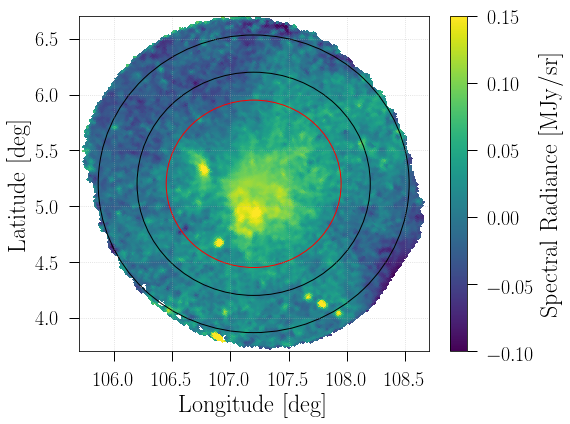

In [17]:
pc = pcolormesh(X, Y, x.data, rasterized=True)
clim(-0.1, 0.15)
cm = colorbar();
cm.set_label('$\mathrm{Spectral\ Radiance\ [MJy / sr]}$')

circ1 = Circle((rc, dc), (45./60), facecolor='None', lw=1, edgecolor='r')
circ2 = Circle((rc, dc), (60./60), facecolor='None', lw=1, edgecolor='k')
circ3 = Circle((rc, dc), (80./60), facecolor='None', lw=1, edgecolor='k')
pc.axes.add_patch(circ1)
pc.axes.add_patch(circ2)
pc.axes.add_patch(circ3)

xlim(lonra)
ylim(latra)
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
grid(ls='dotted', alpha=0.5)
xlim(105.7, 108.7)
ylim(3.7, 6.7)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()
savefig('../notebooks/GBT_bankC_destriped_deplaned_aperture.pdf', format='pdf', dpi=300)

In [31]:
rdmesh = meshgrid(X, Y)
radius_grid = np.sqrt( (rdmesh[0] - lonc)**2 + (rdmesh[1] - latc)**2 ) 

In [32]:
rads = radius_grid.flatten()
fluxs = x.data.flatten()
mask = np.isnan(fluxs)
fluxs = fluxs[~mask]
rads = rads[~mask]

mask2 = rads <= (90./60.)
fluxs = fluxs[mask2]
rads = rads[mask2]

In [33]:
histo, bins = np.histogram(rads, bins=45, weights=fluxs)

In [34]:
histnorm, bins2 = np.histogram(rads, bins=45)

In [35]:
bins = (bins[1:] + bins[:-1])/2.

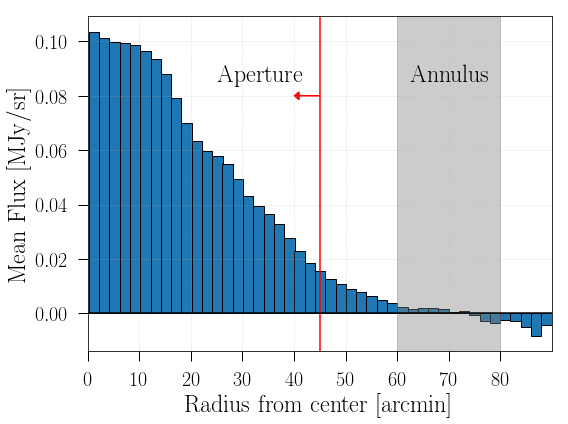

In [74]:
bar(x=bins * 60., height=histo/histnorm, width=2., edgecolor='k')
grid(ls='dotted', alpha=0.5)
xlabel('$\mathrm{Radius\ from\ center\ [arcmin]}$')
ylabel('$\mathrm{Mean\ Flux\ [MJy/sr]}$')
xticks(np.linspace(0, 80, 9));
axvspan(60, 80, color='grey', alpha=0.4)
axvline(45, color='r')
arrow(45, 0.08, -5, 0, color='r', head_width=0.003, head_length=1, width=0.0001, length_includes_head=True)
xlim(0, 90)
axhline(0, color='k')
text(62.5, 0.085, '$\mathrm{Annulus}$', fontsize=24)
text(25, 0.085, '$\mathrm{Aperture}$', fontsize=24)
tight_layout()
savefig('flux_radius_binned_destriped_deplaned_bankA.pdf', format='pdf')